<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/13_rnn/05_Attention_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google ColabでGoogleドライブをマウントする
* 以下のコードを実行するとURLが出てくるので，クリック
* Googleアカウントに許可を求めたらcodeが出るのでコピー
* コピーしたcodeを[空白]にペースト

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Attention Seq2seq
前セクションのAttention Seq2seqの問題設定を少し変えてみましょう．Attention機構は，機械翻訳や文章生成，質問応答など幅広いタスクで応用できます．本セクションでは日付変換，つまり(曜日，日付，年数)を(年数-月-日)に変換させるAttention Seq2seqで解きます．

<img src="https://drive.google.com/uc?export=view&id=1ssOyXFejFeptoO5dFDVBw_LNUguiUonO" width = 100%>

In [ ]:
!wget -q "https://drive.google.com/uc?export=download&id=1FKO72lVQ-yNpktQLvj93R2eE9AZJgbLs" -O date.txt

In [ ]:
import numpy as np
file_path = "./date.txt"
input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])
print(output_date)

['_1994-09-27', '_2003-08-19', '_1993-02-10', '_1990-10-31', '_1984-09-25', '_2013-06-17', '_1996-04-03', '_1974-10-24', '_1986-08-11', '_2015-02-16', '_1988-10-12', '_1973-06-03', '_1981-09-30', '_1977-06-19', '_2005-10-22', '_2013-12-01', '_1997-02-26', '_1991-09-10', '_2016-03-27', '_1983-04-14', '_1982-10-02', '_1996-04-26', '_1979-12-21', '_2012-09-04', '_1994-04-19', '_1995-05-14', '_2004-08-14', '_2007-03-03', '_2012-09-22', '_2010-11-21', '_2011-07-18', '_1987-02-22', '_1987-04-15', '_2012-07-12', '_2001-06-12', '_1997-09-08', '_1994-08-29', '_2002-03-20', '_1982-11-02', '_2004-04-22', '_1992-04-07', '_2016-09-25', '_2004-12-26', '_2008-06-05', '_2005-08-29', '_1980-03-08', '_2013-07-10', '_2004-09-30', '_2005-04-24', '_1999-08-22', '_1993-05-06', '_1975-10-22', '_1997-10-25', '_1976-06-27', '_2013-05-18', '_1996-11-03', '_1981-03-10', '_1979-01-06', '_2013-01-07', '_2011-04-21', '_1973-05-09', '_2003-01-21', '_1991-06-05', '_1983-12-27', '_2005-01-29', '_2005-01-17', '_2014-07

#データ準備
日付変換をするために， ０から学ぶDeep Learning2のGithubからデータを拝借します．リンク先はこちらです．date.txtのlink[https://drive.google.com/file/d/1FKO72lVQ-yNpktQLvj93R2eE9AZJgbLs/view?usp=sharing] ．date.txtを事前にgoogle driveに格納します．date.txtを学習用と評価用に分割するのと，必要に応じてデータを整理します．

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# 事前にGoogle Driveをマウントして以下の場所にdate.txtを格納しておきます
file_path = "/content/drive/My Drive/Colab_Notebooks/date.txt"

input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
  for c in input_chars:
    if not c in char2id:
      char2id[c] = len(char2id)
  for c in output_chars:
    if not c in char2id:
      char2id[c] = len(char2id)

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
  if len([char2id[c] for c in output_chars]) != 11:
    char2id_ = [char2id[c] for c in output_chars]
    char0list = [0 for i in range(11-len([char2id[c] for c in output_chars]))]
    char2id_.extend(char0list)
    output_data.append(char2id_)
  else:
    output_data.append([char2id[c] for c in output_chars])
  input_data.append([char2id[c] for c in input_chars])
# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

###エンコーダ・デコーダの作成
基本的な構造は前セクションのエンコーダ・デコーダ構造と同様です．ただし，エンコーダは各時刻の出力値を保持しておきます．デコーダでは，保持したエンコーダの出力値とデコーダの出力値で内積計算します．この内積計算によって，各時刻のエンコーダの出力値に重み付けすることができます．これにより，どの時刻のエンコーダの出力に着目したかをデコーダ側が自動で決定することができます．

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim

# 諸々のパラメータなど
embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
learning_rate = 0.001
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
        return hs, h

# Attention Decoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim*2としているのは、各系列のGRUの隠れ層とAttention層で計算したコンテキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # 列方向を確率変換したいのでdim=1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

        t_output = torch.transpose(output, 1, 2) 
        s = torch.bmm(hs, t_output) 
        attention_weight = self.softmax(s)
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device)

        # Attention weight
        for i in range(attention_weight.size()[2]): 
          unsq_weight = attention_weight[:,:,i].unsqueeze(2) 
          weighted_hs = hs * unsq_weight 
          weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1)
          c = torch.cat([c, weight_sum], dim=1) 
        c = c[:,1:,:]
        output = torch.cat([output, c], dim=2)
        output = self.hidden2linear(output)
        return output, state, attention_weight

#モデル定義，損失関数，最適化手法
EncoderとAttentionDecoderに各パラメータを引数として入れます．損失関数にはCrossEntropyLossを用います．pytorchのCrossEntropyLossには内部にSoftmax関数を持つため，ネットワークの出力後にSoftmax関数を割り当てる必要はありません．最適化手法にはAdamを使用します．

In [ ]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)

#学習
* lossが0.1を下回ったら終了とします

In [ ]:
BATCH_NUM=100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]

        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 0.1: break
print("Done")

training ...
torch.Size([100, 10, 200]) torch.Size([100, 29, 128])


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#学習推移の可視化

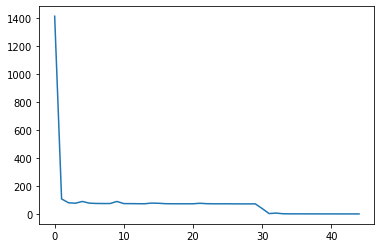

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

#評価
表は入力，教師，デコーダの予測出力，正答率を表します

In [ ]:
import pandas as pd

# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味します
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad():
    hs, encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    for _ in range(output_len - 1):
      decoder_output, decoder_hidden, _ = attn_decoder(decoder_input_tensor, hs, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
    predicts.append(batch_tmp[:,1:])


# 予測結果を見る際にIDのままだと可読性が悪いので、もとの文字列に復元するためのID→文字列に変換する辞書を定義
id2char = {}
for k, v in char2id.items():
  id2char[v] = k

row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[idx] for idx in inp]
    y = [id2char[idx] for idx in output[1:]]
    p = [id2char[idx.item()] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
predict_df.head()

NameError: ignored

In [ ]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))

predict_df.query('judge == "X"').head(10)

0.9999333333333333


,input,answer,predict,judge
8008,8/3/99,1999-08-03,1993-08-03,X


# Attentionの可視化
* 横軸がEncoderの入力，縦軸が生成文字を表しています
* 生成文字を１文字ずつ見たとき、左に並んでいるボックスの色が一番明るいところの文字が一番attentionして生成された文字を表しています

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


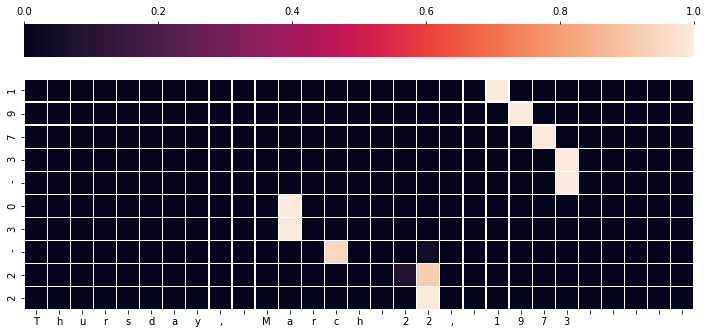

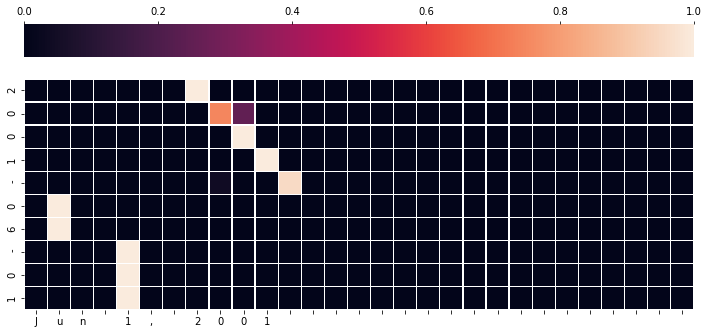

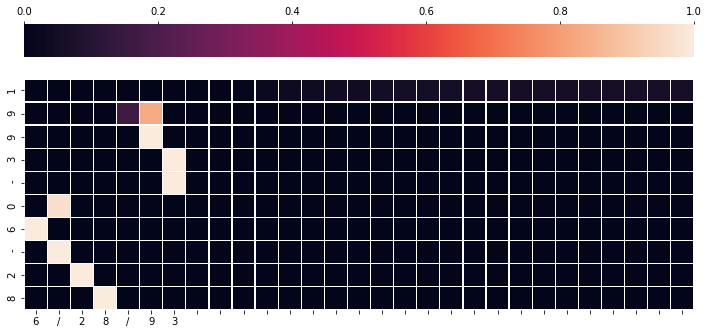

In [ ]:
import seaborn as sns
import pandas as pd

input_batch, output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_minibatch, output_minibatch = input_batch[0], output_batch[0]

with torch.no_grad():
  # データをテンソルに変換
  input_tensor = torch.tensor(input_minibatch, device=device)
  output_tensor = torch.tensor(output_minibatch, device=device)
  hs, h = encoder(input_tensor)
  source = output_tensor[:, :-1]
  decoder_output, _, attention_weight= attn_decoder(source, hs, h)


for i in range(3):
  with torch.no_grad():
    df = pd.DataFrame(data=torch.transpose(attention_weight[i], 0, 1).cpu().numpy(), 
                      columns=[id2char[idx.item()] for idx in input_tensor[i]], 
                      index=[id2char[idx.item()] for idx in output_tensor[i][1:]])
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(df, xticklabels = 1, yticklabels = 1, square=True, linewidths=.3,cbar_kws = dict(use_gridspec=False,location="top"))

#課題
* GRUの他にRNNやLSTMを試してみよう
* 色々なAttentionの可視化から考察してみよう